## 策略迭代和价值迭代

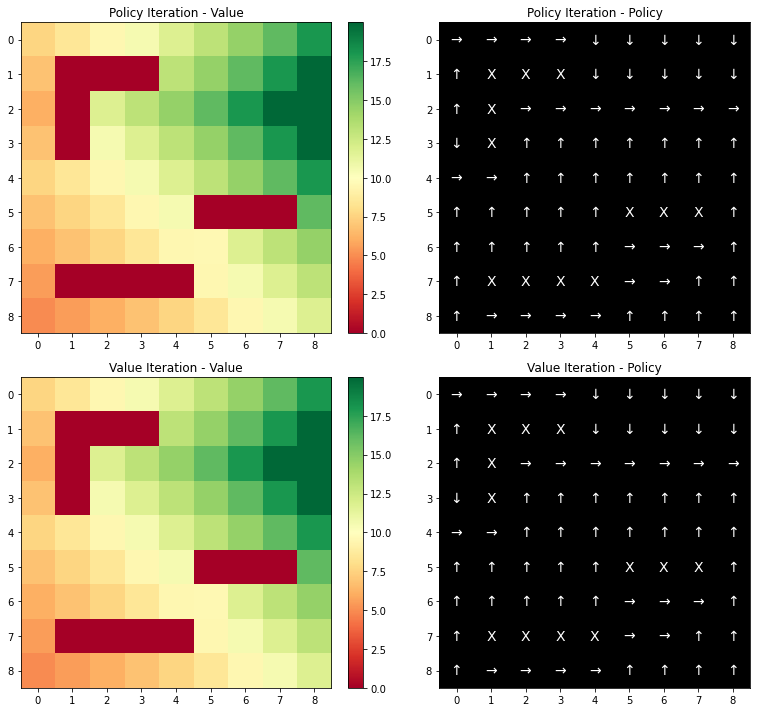

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#=============== 1. ENVIRONMENT DEFINITION ===============
N = 9                  # 9x9 grid
gamma = 0.9            # Discount factor
epsilon = 1e-4         # Convergence threshold

# Movements: Up, Down, Left, Right
ACTIONS = {
    'U': (-1, 0),
    'D': ( 1, 0),
    'L': ( 0,-1),
    'R': ( 0, 1),
}
action_list = list(ACTIONS.keys())

# Example walls (obstacles)
WALLS = {
    (1,1), (1,2), (1,3),
    (2,1), (3,1),
    (5,5), (5,6), (5,7),
    (7,1), (7,2), (7,3), (7,4)
}

# Default reward at each cell
rewards = -0.02 * np.ones((N, N))
# Special cells with custom rewards
rewards[2,8] = +2.0
rewards[6,6] = -1.0

def step(r, c, action):
    """
    Execute 'action' from state (r,c).
    If the next cell is a wall or out of bounds, stay put.
    Returns (nr, nc), immediate_reward.
    """
    dr, dc = ACTIONS[action]
    nr, nc = r + dr, c + dc
    if not (0 <= nr < N and 0 <= nc < N):
        nr, nc = r, c
    if (nr, nc) in WALLS:
        nr, nc = r, c
    return (nr, nc), rewards[nr, nc]

#=============== 2. POLICY ITERATION ===============
def policy_iteration():
    """
    1) Initialize a random policy pi
    2) Policy Evaluation: iterative until V^pi converges
    3) Policy Improvement: greedy update
    4) If policy stable, stop
    Returns (V, pi)
    """
    pi = np.random.choice(action_list, size=(N, N))
    V = np.zeros((N, N), dtype=np.float32)
    
    while True:
        #--- 2.1 Policy Evaluation ---
        while True:
            delta = 0.0
            new_V = np.copy(V)
            for r in range(N):
                for c in range(N):
                    if (r,c) in WALLS:
                        new_V[r,c] = 0.0
                        continue
                    a = pi[r, c]
                    (nr, nc), rwd = step(r, c, a)
                    new_V[r, c] = rwd + gamma * V[nr, nc]
            delta = np.abs(new_V - V).max()
            V = new_V
            if delta < epsilon:
                break
        
        #--- 2.2 Policy Improvement ---
        policy_stable = True
        for r in range(N):
            for c in range(N):
                if (r,c) in WALLS:
                    continue
                old_action = pi[r, c]
                best_val = -1e9
                best_act = old_action
                for a in action_list:
                    (nr, nc), rwd = step(r, c, a)
                    q_val = rwd + gamma * V[nr, nc]
                    if q_val > best_val:
                        best_val = q_val
                        best_act = a
                pi[r, c] = best_act
                if best_act != old_action:
                    policy_stable = False
        if policy_stable:
            break
    
    return V, pi

#=============== 3. VALUE ITERATION ===============
def value_iteration():
    """
    Iterative update using Bellman optimality.
    Returns (V, pi)
    """
    V = np.zeros((N, N), dtype=np.float32)
    
    while True:
        delta = 0.0
        new_V = np.copy(V)
        for r in range(N):
            for c in range(N):
                if (r,c) in WALLS:
                    new_V[r,c] = 0.0
                    continue
                best_val = -1e9
                for a in action_list:
                    (nr, nc), rwd = step(r, c, a)
                    q_val = rwd + gamma * V[nr, nc]
                    if q_val > best_val:
                        best_val = q_val
                new_V[r, c] = best_val
        delta = np.abs(new_V - V).max()
        V = new_V
        if delta < epsilon:
            break
    
    # Greedy policy from final V
    pi = np.full((N, N), '', dtype='<U1')
    for r in range(N):
        for c in range(N):
            if (r,c) in WALLS:
                pi[r, c] = ' '  # no action in walls
                continue
            best_val = -1e9
            best_act = ' '
            for a in action_list:
                (nr, nc), rwd = step(r, c, a)
                q_val = rwd + gamma * V[nr, nc]
                if q_val > best_val:
                    best_val = q_val
                    best_act = a
            pi[r, c] = best_act
    
    return V, pi


# (1) Policy Iteration
V_pi, pi_pi = policy_iteration()
# (2) Value Iteration
V_vi, pi_vi = value_iteration()

# Create subplots: 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# (A) Policy Iteration - Value
im1 = axes[0].imshow(V_pi, cmap='RdYlGn', origin='upper')
axes[0].set_title("Policy Iteration - Value")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# (B) Policy Iteration - Policy
axes[1].set_title("Policy Iteration - Policy")
# Just draw a blank background on which we place text arrows
axes[1].imshow(np.zeros_like(V_pi), cmap='gray', origin='upper')
for r in range(N):
    for c in range(N):
        if (r,c) in WALLS:
            # Mark walls with 'X'
            axes[1].text(c, r, 'X', ha='center', va='center',
                            color='white', fontsize=14)
        else:
            arrow = {
                'U': '↑',
                'D': '↓',
                'L': '←',
                'R': '→'
            }.get(pi_pi[r, c], '')
            axes[1].text(c, r, arrow, ha='center', va='center', fontsize=14,color='white')

# (C) Value Iteration - Value
im2 = axes[2].imshow(V_vi, cmap='RdYlGn', origin='upper')
axes[2].set_title("Value Iteration - Value")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# (D) Value Iteration - Policy
axes[3].set_title("Value Iteration - Policy")
axes[3].imshow(np.zeros_like(V_vi), cmap='gray', origin='upper')
for r in range(N):
    for c in range(N):
        if (r,c) in WALLS:
            axes[3].text(c, r, 'X', ha='center', va='center',
                            color='white', fontsize=14)
        else:
            arrow = {
                'U': '↑',
                'D': '↓',
                'L': '←',
                'R': '→'
            }.get(pi_vi[r, c], '')
            axes[3].text(c, r, arrow, ha='center', va='center', fontsize=14,color='white')

plt.tight_layout()
plt.show()


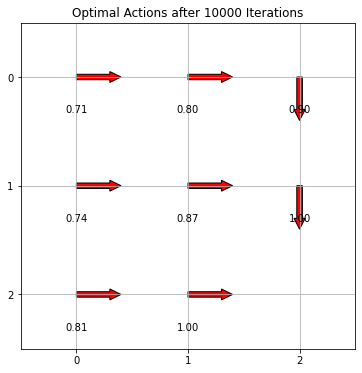

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 环境参数
GRID_SIZE = 3
ACTIONS = ['up', 'down', 'left', 'right']
N_ACTIONS = len(ACTIONS)
GAMMA = 0.9      # 折扣因子
ALPHA = 0.1      # 学习率
EPSILON = 0.2    # 探索率
N_ITERATIONS = 10000  # 总迭代次数

# 乐观初始化 Q 表，并加入少量噪声以打破平局
Q = np.ones((GRID_SIZE, GRID_SIZE, N_ACTIONS)) + np.random.rand(GRID_SIZE, GRID_SIZE, N_ACTIONS) * 0.1

# ε-soft 目标策略：对于某状态下，
# 贪心动作的概率为 1 - EPSILON + EPSILON/N_ACTIONS，其它动作为 EPSILON/N_ACTIONS
def target_policy_prob(state, action_idx):
    greedy_action = np.argmax(Q[state[0], state[1]])
    if action_idx == greedy_action:
        return 1 - EPSILON + EPSILON / N_ACTIONS
    else:
        return EPSILON / N_ACTIONS

# 行为策略：ε-greedy
def behavior_policy(state):
    if np.random.rand() < EPSILON:
        return np.random.randint(N_ACTIONS)
    else:
        return np.argmax(Q[state[0], state[1]])

# 生成一个 episode（完整轨迹）
def generate_episode():
    state = (0, 0)  # 初始状态（左上角）
    episode = []
    for _ in range(20):  # 最大步数限制
        action_idx = behavior_policy(state)
        action = ACTIONS[action_idx]
        # 模拟状态转移
        next_state = list(state)
        if action == 'up' and state[0] > 0:
            next_state[0] -= 1
        elif action == 'down' and state[0] < GRID_SIZE - 1:
            next_state[0] += 1
        elif action == 'left' and state[1] > 0:
            next_state[1] -= 1
        elif action == 'right' and state[1] < GRID_SIZE - 1:
            next_state[1] += 1
        next_state = tuple(next_state)
        # 计算奖励：仅在到达终止状态时奖励为 1
        reward = 1 if next_state == (GRID_SIZE - 1, GRID_SIZE - 1) else 0
        episode.append((state, action_idx, reward))
        if reward == 1:  # 到达目标状态，结束 episode
            break
        state = next_state
    return episode

# Off-policy MC 更新（重要性采样）
def off_policy_mc_update(episode):
    G = 0  # 累积回报
    rho = 1.0  # 重要性采样权重
    # 反向遍历轨迹
    for t in reversed(range(len(episode))):
        state, action_idx, reward = episode[t]
        G = reward + GAMMA * G
        # 计算目标策略和行为策略的概率
        target_prob = target_policy_prob(state, action_idx)
        # 行为策略下的概率：对于 ε-greedy 策略，同样为 ε-soft 概率分布
        if action_idx == np.argmax(Q[state[0], state[1]]):
            behavior_prob = (1 - EPSILON) + EPSILON / N_ACTIONS
        else:
            behavior_prob = EPSILON / N_ACTIONS
        # 更新重要性采样权重（避免除 0）
        if behavior_prob > 0:
            rho *= (target_prob / behavior_prob)
        else:
            rho = 0.0
        # 更新 Q 值
        Q[state[0], state[1], action_idx] += ALPHA * rho * (G - Q[state[0], state[1], action_idx])

# 运行迭代
for i in range(N_ITERATIONS):
    episode = generate_episode()
    off_policy_mc_update(episode)

# 可视化每个状态的最优动作（终止状态除外）
action_vectors = {
    'up': (-0.3, 0),
    'down': (0.3, 0),
    'left': (0, -0.3),
    'right': (0, 0.3)
}

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(-0.5, GRID_SIZE - 0.5)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.grid(True)
ax.set_title(f"Optimal Actions after {N_ITERATIONS} Iterations")

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        if (i, j) == (GRID_SIZE - 1, GRID_SIZE - 1):
            continue  # 终止状态
        best_action_idx = np.argmax(Q[i, j])
        best_action = ACTIONS[best_action_idx]
        dx, dy = action_vectors[best_action]
        ax.arrow(j, i, dy, dx, head_width=0.1, head_length=0.1,
                 fc='red', ec='black', width=0.05)
        ax.text(j, i + 0.3, f'{Q[i,j,best_action_idx]:.2f}', ha='center', va='center', fontsize=10)

plt.gca().invert_yaxis()  # 保证 (0,0) 在左上角
plt.show()
